In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

In [2]:
#create Spark session
spark = SparkSession.builder.appName('YelpML').getOrCreate()

#change configuration settings on Spark 
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '5g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','8g')])

#print spark configuration settings
#spark.sparkContext.getConf().getAll()

In [3]:
# Import Data
dataDir = "gs://msca-bdp-student-gcs/group2/yelp-datasample2"
business = spark.read.json(dataDir + "/sample_business")
checkin = spark.read.json(dataDir + "/sample_checkin")
review = spark.read.json(dataDir + "/sample_review")
tip = spark.read.json(dataDir + "/sample_tip")
user = spark.read.json(dataDir + "/sample_user")

23/08/07 05:04:07 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [4]:
business.show(5)

+-------------------+--------------------+--------------------+--------------------+-------------------+--------------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+
|            address|          attributes|         business_id|          categories|               city|               hours|is_open|     latitude|     longitude|                name|postal_code|review_count|stars|state|
+-------------------+--------------------+--------------------+--------------------+-------------------+--------------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+
|      2141 Caton St|{null, null, null...|FR5xx5YEzxAnoMdqG...|Fitness & Instruc...|        New Orleans|{0:0-0:0, 0:0-0:0...|      1|   29.9991154|   -90.0607732|     Anytime Fitness|      70122|           6|  3.0|   LA|
|5413 Neshaminy Blvd|{null, null, u'no...|p184f-Zvf4ToPwLba...|Chinese, Restaura...|           Bensalem|{11:30-23:0,

In [5]:
from pyspark.sql.functions import isnan, when, count
business.select([count(when(business[c].isNull(), c)).alias(c) for c in business.columns]).show()

+-------+----------+-----------+----------+----+-----+-------+--------+---------+----+-----------+------------+-----+-----+
|address|attributes|business_id|categories|city|hours|is_open|latitude|longitude|name|postal_code|review_count|stars|state|
+-------+----------+-----------+----------+----+-----+-------+--------+---------+----+-----------+------------+-----+-----+
|      0|       170|          0|         2|   0|  250|      0|       0|        0|   0|          0|           0|    0|    0|
+-------+----------+-----------+----------+----+-----+-------+--------+---------+----+-----------+------------+-----+-----+



In [6]:
# 1. How many unique business?
business.select('business_id').distinct().count()

1617

In [7]:
# 2. What are the top 10 categories?
business.select('categories').distinct().show(truncate = False)

+-----------------------------------------------------------------------------------------------------------------------+
|categories                                                                                                             |
+-----------------------------------------------------------------------------------------------------------------------+
|African, American (Traditional), Restaurants                                                                           |
|Cosmetics & Beauty Supply, Nail Salons, Shopping, Beauty & Spas                                                        |
|Parks, Active Life                                                                                                     |
|Obstetricians & Gynecologists, Health & Medical, Doctors                                                               |
|Shopping, Food, Drugstores, Pharmacy, Health & Medical, Convenience Stores                                             |
|Food, Ice Cream & Froze

In [8]:
from pyspark.sql.functions import explode, split
business = business.withColumn('categories_split', explode(split('categories', ', ')))

In [9]:
df1 = business.groupby('categories_split').count().orderBy('count', ascending = [0])

In [10]:
df1.show(10, truncate = False)

+----------------+-----+
|categories_split|count|
+----------------+-----+
|Restaurants     |589  |
|Food            |303  |
|Shopping        |264  |
|Beauty & Spas   |154  |
|Home Services   |145  |
|Health & Medical|132  |
|Automotive      |129  |
|Nightlife       |124  |
|Bars            |113  |
|Local Services  |111  |
+----------------+-----+
only showing top 10 rows



In [11]:
pdf1 = df1.toPandas()
pdf1.head()

,categories_split,count
0,Restaurants,589
1,Food,303
2,Shopping,264
3,Beauty & Spas,154
4,Home Services,145


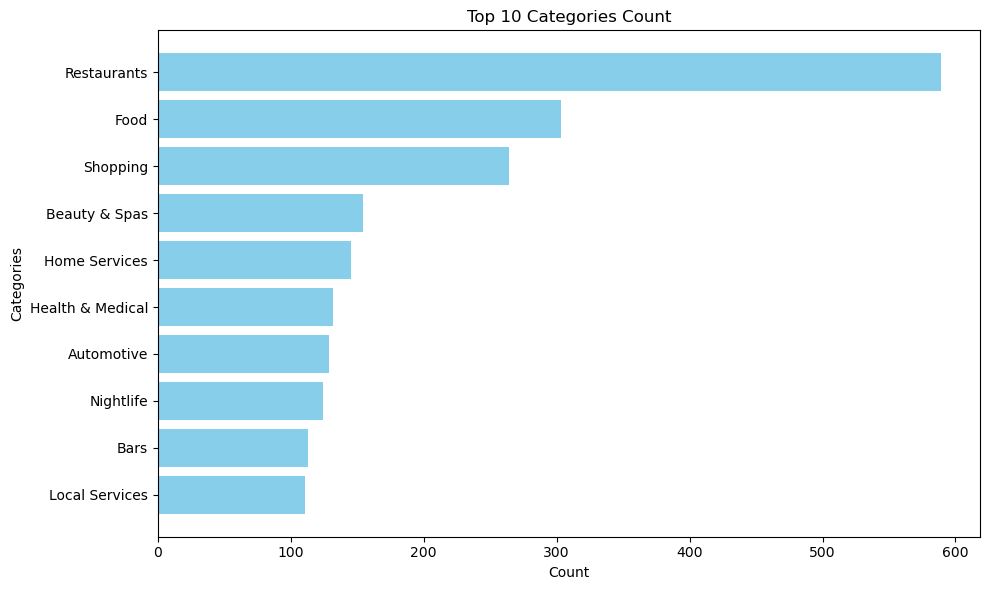

In [12]:
top_10_categories = pdf1.head(10)

plt.figure(figsize=(10, 6))
plt.barh(top_10_categories['categories_split'], top_10_categories['count'], color='skyblue')
plt.xlabel('Count')
plt.ylabel('Categories')
plt.title('Top 10 Categories Count')
plt.gca().invert_yaxis()  
plt.tight_layout()

# Display the plot
plt.show()

In [13]:
# 3. Business Location

In [14]:
df2 = business.groupby('state').count().orderBy('count', ascending =[0])

In [15]:
df2.show()

+-----+-----+
|state|count|
+-----+-----+
|   PA| 1715|
|   FL| 1310|
|   MO|  591|
|   TN|  563|
|   IN|  495|
|   AZ|  468|
|   LA|  454|
|   NJ|  425|
|   NV|  330|
|   CA|  243|
|   ID|  217|
|   AB|  188|
|   IL|  109|
|   DE|   77|
|   WA|    2|
+-----+-----+



In [16]:
pdf2 = df2.toPandas()
pdf2.head()

,state,count
0,PA,1715
1,FL,1310
2,MO,591
3,TN,563
4,IN,495


ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/miniconda3/share/proj failed


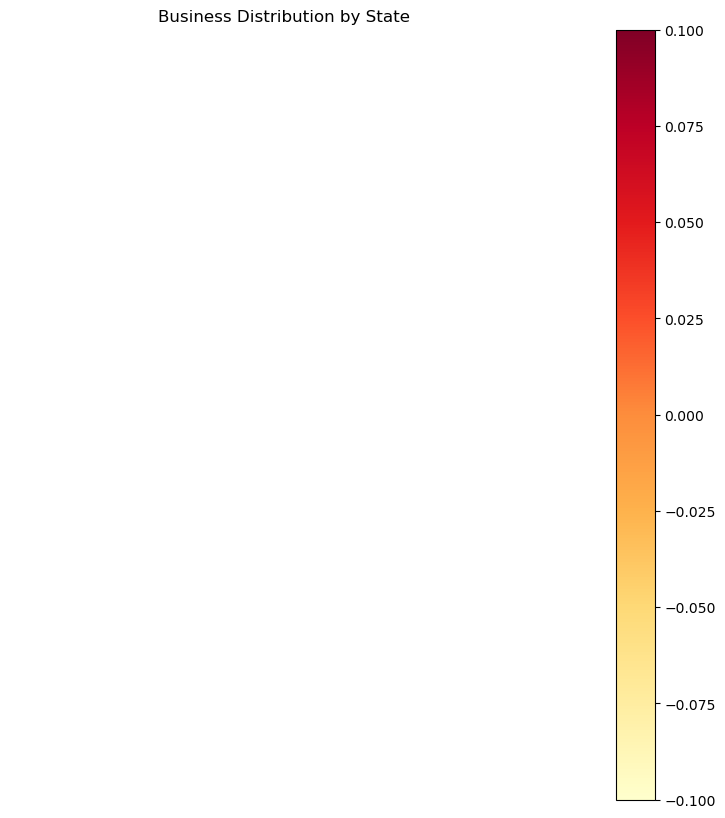

In [17]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Load the US states GeoJSON file
us_states = gpd.read_file('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json')

# Your DataFrame
data = {
    'state': ['PA', 'FL', 'MO', 'TN', 'IN', 'AZ', 'LA', 'NJ', 'NV', 'CA', 'ID', 'AB', 'IL', 'DE', 'WA'],
    'count': [1715, 1310, 591, 563, 495, 468, 454, 425, 330, 243, 217, 188, 109, 77, 2]
}
pdf2 = pd.DataFrame(data)

# Merge with the GeoDataFrame
merged = us_states.merge(pdf2, left_on='id', right_on='state', how='left')

# Create a figure and axis
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot the map
merged.plot(column='count', cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# Add a title
plt.title('Business Distribution by State')

# Remove the axis
ax.set_axis_off()

# Show the plot
plt.show()


In [18]:
#pip install plotly-express

In [ ]:
import plotly.express as px

data = {
    'state': ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY'],
    'count': [0] * 50  # You can update this count with your desired values
}

pdf2 = pd.DataFrame(data)

fig = px.choropleth(pdf2,
                    locations= 'state', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='count',
                    color_continuous_scale="Viridis_r")
fig.show()

In [21]:
checkin.show()

+--------------------+--------------------+
|         business_id|                date|
+--------------------+--------------------+
|SHZ3NhQj1FonMnKgd...|2010-03-07 03:15:...|
|SIc1YcqUBMdXO3Lxg...|2017-08-14 18:44:...|
|SJ3iTeHq3Om0SoruO...|2010-11-25 17:17:...|
|SLWMy4MsvvAAtiyYr...|2011-07-20 21:38:...|
|SN0cn8cxbTWiAhtP-...|2012-06-15 13:20:...|
|SOKZiTA5hhGGsAuAI...|2014-09-28 05:57:...|
|SekWxm92phAL_P_Ky...|2010-03-08 01:46:...|
|ShJiM9L-skL5Hd7RM...| 2012-06-24 21:11:48|
|SjEOtdNuQfBWZL0pZ...|2020-06-12 04:08:...|
|SoPn5xN-6AElJwsja...| 2017-12-08 18:17:56|
|StN1Kre3qoBwvbqv5...| 2013-08-08 16:51:13|
|Sw53KWMB8cYjF7EZX...|2015-09-30 00:41:...|
|SwJOeRUW0mFYDXTgJ...|2010-07-10 15:26:...|
|Swox1WnwaKpd20hog...| 2017-06-30 12:12:58|
|Sz5Gv-wehJpOQNH1u...|2015-02-13 17:32:...|
|T-BcPfWiAz5dRKWkQ...|2019-02-03 09:27:...|
|T0TOtx8E71DqO5Al5...|2011-12-29 21:13:...|
|T4VkmVfJScbLe21xL...|2010-07-12 16:16:...|
|T9JtKc0o9ApuVXg2z...|2012-12-29 19:16:...|
|TAX9sFriCKBeigt-t...| 2012-12-3

In [22]:
review.show()

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|arKiXax3ScSM_z3O-...|   0|2010-10-17 01:50:46|    0|zCNdcNrkIKefTPbak...|  5.0|Great Italian foo...|     0|bz2FrqfKrVmS7WwC-...|
|aeFXIzYpWjSdtq5w8...|   3|2013-06-29 13:42:57|    0|aweHR8S6QAEuV4hoH...|  3.0|I have heard many...|     4|CAU7F-vDqbQZ67BBY...|
|rAytSQU5RQHvXe1Wl...|   1|2021-02-03 21:32:58|    0|CefnkUvmbiDsexuxz...|  5.0|I wish this locat...|     2|BHcPaG4X220bQsqOR...|
|uFLqtC7Yq03dDrxU0...|   2|2013-02-09 13:23:26|    2|geSJqq4MUPos2l8ZI...|  4.0|Why I like Smooth...|     7|DAeC-Y66n-jNMJJw4...|
|3u1cP7H4g325tkhNE...|   0|2021-01-02 17:01:16|    0|P0gEHckZurgPi7_7f...|  5.0|I rarely g

In [23]:
tip.show(5)

+--------------------+----------------+-------------------+--------------------+--------------------+
|         business_id|compliment_count|               date|                text|             user_id|
+--------------------+----------------+-------------------+--------------------+--------------------+
|-ib2qJmDKJgH_ZbtS...|               0|2017-01-08 03:26:27|My favorite pizza...|mxKNFsLCMSSFanV0o...|
|rTXNiH-RROF1OQHVI...|               0|2013-06-23 17:18:01|Everything is gre...|4af7IWHRc890BUKcA...|
|1Z9y1CQj1BZjdFJGu...|               0|2014-01-10 23:51:00|Having a good tim...|-iC2-qwz19U7Xr4af...|
|qUSrh_Zya0O1sRffR...|               0|2012-04-28 01:07:40|        Soccer party|wAgg_B9OQzL8_UF8o...|
|jziRKhtHxeJPAPWS2...|               0|2010-08-22 01:22:08|Sit at the Bar......|Ye-9S8f2dt41UBfy4...|
+--------------------+----------------+-------------------+--------------------+--------------------+
only showing top 5 rows



In [24]:
user.show()

+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+----+-----+----+-------+-----+--------+------------+------+--------------------+-------------------+
|average_stars|compliment_cool|compliment_cute|compliment_funny|compliment_hot|compliment_list|compliment_more|compliment_note|compliment_photos|compliment_plain|compliment_profile|compliment_writer|cool|elite|fans|friends|funny|    name|review_count|useful|             user_id|      yelping_since|
+-------------+---------------+---------------+----------------+--------------+---------------+---------------+---------------+-----------------+----------------+------------------+-----------------+----+-----+----+-------+-----+--------+------------+------+--------------------+-------------------+
|          4.5|              0|              0|               0|             0|              0|     